# BACE1

### Импорт и обработка данных

In [9]:
import pandas as pd
import numpy as np

import os, random, time, json, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from openai import OpenAI

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed as hf_set_seed

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, MACCSkeys
from rdkit import RDLogger
from rdkit.Contrib.SA_Score import sascorer
from rdkit.Chem import Descriptors, QED, Lipinski, Crippen, rdMolDescriptors
from rdkit.Chem import FilterCatalog
from rdkit.Chem import Descriptors, Lipinski, Crippen, rdMolDescriptors, FilterCatalog

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.


In [10]:
import argparse, time, random, os
import numpy as np
import pandas as pd

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [11]:
# импортируем данные с IC50 и Ki из chembl
def import_chembl(li):
    dfs = []
    for path in li:
        dfs.append(pd.read_excel(path))
    df = pd.concat(dfs, axis=0).reset_index(drop=True)
    
    mask = df['Standard Relation'].isin([repr('=')])
    df = df.loc[mask]
    
    # оставляем только нужные столбцы и удаляем NA
    cols = ['Molecule ChEMBL ID', 'Smiles', 'Standard Value', 'Standard Units', 'Molecular Weight', "Standard Type"]
    df = df[cols]
    df = df.dropna().reset_index(drop=True)
    
    # конвертация ug.mL-1 → nM
    mask = df['Standard Units'].isin(['nM', 'ug.mL-1'])
    df = df.loc[mask].copy()
    
    convert_mask = df['Standard Units'] == 'ug.mL-1'
    df.loc[convert_mask, 'Standard Value'] = (
        df.loc[convert_mask, 'Standard Value'] * 1e3
        / df.loc[convert_mask, 'Molecular Weight']
    )
    df.loc[convert_mask, 'Standard Units'] = 'nM'
    df = df.reset_index(drop=True)

    def convert(row):
        val_nM = row["Standard Value"]
        if pd.isna(val_nM) or val_nM <= 0:
            return np.nan
        if row["Standard Type"] in ("IC50", "Ki"):
            return 9 - np.log10(val_nM)
        else:
            return np.nan
    
    df["pActivity"] = df.apply(convert, axis=1)
    
    # Удаляем строки с NaN в pIC50 и фильтруем положительные значения
    df = df.dropna(subset=["pActivity"])
    df = df[df["pActivity"] > 0]
    
    # оставляем только нужные столбцы
    cols = ['Molecule ChEMBL ID', 'Smiles', 'pActivity', "Standard Type"]
    df = df[cols]
    df.rename({'Molecule ChEMBL ID': 'id', "Standard Type": 'type'}, inplace=True, axis=1)
    return df
df = import_chembl(['bace.xlsx', 'bace_ki.xlsx'])
df

,id,Smiles,pActivity,type
0,CHEMBL311262,CC(C)[C@H](NC(=O)[C@@H](N)CCC(=O)O)C(=O)N[C@@H...,7.309804,IC50
1,CHEMBL49971,CC(C)C[C@H](NC(=O)C(O)c1ccccc1Br)[C@@H](O)CC(=...,4.397940,IC50
2,CHEMBL297910,CC(C)CC(NC(=O)C(O)c1cccc2ccccc12)[C@@H](O)CC(=...,5.397940,IC50
3,CHEMBL381826,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CNC(=O...,8.318759,IC50
4,CHEMBL1824337,CN1C(=O)C(c2cccc(-c3cccnc3F)c2)(c2cnn(CCF)c2)N...,7.301030,IC50
...,...,...,...,...
11466,CHEMBL3902472,CCNS1(O)C[C@@](C)(c2cc(NC(=O)c3ccc(Cl)cn3)ccc2...,8.154902,Ki
11467,CHEMBL3956676,CNS1(O)C[C@@](C)(c2cc(NC(=O)c3ccc(Cl)cn3)ccc2F...,8.096910,Ki
11468,CHEMBL3948430,CNS1(O)C[C@@](C)(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)...,8.000000,Ki
11469,CHEMBL3916243,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)C=CSC(N...,9.886057,Ki


In [12]:
# импортируем данные с IC50 и Ki из BindingDB
def import_bdb(path):
    df3 = pd.read_excel(path)

    # Оставляем данные по Homo sapiens
    mask = (
        df3['Target Source Organism According to Curator or DataSource'].isin(['Homo sapiens'])
    )
    df3 = df3.loc[mask]

    # функция для логарифмирования IC50 и Ki в нМ
    def calculate_pActivity(value):
        if pd.isna(value) or value <= 0:
            return np.nan
        if pd.isna(value):
            return np.nan
        return 9 - np.log10(value)
    
    # Создаём столбец pActivity, объединяя Ki и IC50
    # Приоритет Ki, если оба значения присутствуют
    df3['Ki (nM)'] = pd.to_numeric(df3['Ki (nM)'], errors='coerce')
    df3['IC50 (nM)'] = pd.to_numeric(df3['IC50 (nM)'], errors='coerce')
    df3['pActivity'] = df3['Ki (nM)'].apply(calculate_pActivity)
    df3['type'] = 'Ki'
    mask = df3['pActivity'].isna() & df3['IC50 (nM)'].notna()
    df3.loc[mask, 'pActivity'] = df3.loc[mask, 'IC50 (nM)'].apply(calculate_pActivity)
    df3.loc[mask, 'type'] = 'IC50'
    
    # Удаляем исходные столбцы
    cols = ['BindingDB Reactant_set_id', 'Ligand SMILES', 'pActivity', 'type']
    df3 = df3[cols]
    df3 = df3.dropna().reset_index(drop=True)
    df3.rename({'BindingDB Reactant_set_id': 'id', 'Ligand SMILES': 'Smiles'}, inplace=True, axis=1)
    return df3
df3 = import_bdb('bace3.xlsx')
df3

,id,Smiles,pActivity,type
0,1462063,C#CCOc1cnc(C(=O)Nc2cc(F)c(F)c([C@@]3(C)N=C(N)S...,9.603801,IC50
1,51409641,CC1(Cc2c(F)cncc2C(N)=N1)c1cc(NC(=O)c2ccc(cn2)C...,9.602060,IC50
2,51517117,COc1cc(\C=C\c2nnc(o2)-c2ccc(cc2)C(F)(F)F)ccc1O,9.593460,IC50
3,1462485,COC[C@]12C[C@H]1[C@@](C)(c1cc(NC(=O)c3cnc(OCC(...,9.591760,IC50
4,1461757,C#CCOc1cnc(C(=O)Nc2ccc(F)c([C@@]3(C)N=C(N)S[C@...,9.578396,IC50
...,...,...,...,...
14436,450318,CC1(N=C(N)OC2(CCOCC2)C1(F)F)c1cc(NC(=O)c2ccc(F...,7.508638,IC50
14437,50495909,Cc1noc(C)c1[C@@H]1C[C@](C)(N=C(N)S1)c1cc(NC(=O...,7.508638,IC50
14438,1233489,CC(C)c1cccc(CNC[C@@H](O)[C@@H]2C[C@H](C)CCOCCC...,7.508638,IC50
14439,378224,COc1cnc(cn1)C(=O)Nc1cnc(F)c(c1)[C@]1(C)C[C@H](...,7.508638,IC50


In [13]:
# Вернуть канонический SMILES
def canonize(smi):
    try:
        mol = Chem.MolFromSmiles(str(smi))
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    except Exception:
        return np.nan

# Обработка дубликатов с возвратом медианы при нескольких замерах
def handle_duplicates(df):
    df['Smiles'] = df['Smiles'].map(canonize)
    
    # убираем дубликаты
    df = df.drop_duplicates().reset_index(drop=True)
    
    # Схлопываем реплики: median по (id, type)
    df = (
        df.groupby(["id", "type"], as_index=False)
        .agg({"pActivity": "median", "Smiles": "first"})
    )
    return df

df = pd.concat([df, df3], axis=0).reset_index(drop=True)
df = handle_duplicates(df)
df

,id,type,pActivity,Smiles
0,11799,IC50,7.154902,CCSc1cnc(C(=O)Nc2cccc([C@]3(C)CCSC(N)=N3)c2)cn1
1,23069,IC50,5.224754,C[C@@]1(c2cc(NC(=O)CCc3ccc(O)c(O)c3)ccc2F)CCSC...
2,25935,Ki,8.327902,COc1nc(N2C[C@H]3C(=O)N(C)C(=N)N[C@@]3(c3ccc(F)...
3,26873,Ki,8.050610,COc1nc(N2C[C@H]3C(=O)N(C)C(=N)N[C@@]3(c3cc(F)c...
4,26899,Ki,7.886057,COc1nc(N2C[C@H]3C(=O)N(C)C(=N)N[C@@]3(c3cc(Cl)...
...,...,...,...,...
22684,CHEMBL95430,Ki,8.061891,CC(C)C[C@H](NC(=O)[C@H](CS(C)(=O)=O)NC(=O)[C@@...
22685,CHEMBL97603,Ki,4.979183,CSCC[C@H](NC(=O)[C@@H](NC(=O)OC(C)(C)C)C(C)C)C...
22686,CHEMBL97631,Ki,4.649306,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)OC(C)(C)...
22687,CHEMBL98238,Ki,8.229148,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...


In [14]:
# конвертировать smiles в объекты библиотеки rdkit
def smiles_to_mol(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol
    except Exception:
        return np.nan

# рассчитать все доступные дескрипторы из RDKit
def calc_descriptors(mol):
    values = []
    desc_names = [name for name, _ in Descriptors.descList]
    for name, func in Descriptors.descList:
        values.append(func(mol))
    return pd.Series(values, index=desc_names)

# подготовить столбцы с признаками-факторами для машинного обучения
def prepare_data(df):
    df["mol"] = df["Smiles"].apply(smiles_to_mol)
    df = df.dropna(subset=["mol"]).reset_index(drop=True)
    
    # считаем все доступные дескрипторы
    df_desc = df["mol"].apply(calc_descriptors)
    
    # удаляем наны и нулевую дисперсию
    df_desc = df_desc.dropna(axis=1)
    df_desc = df_desc.loc[:, df_desc.nunique() > 1]
    
    # Рассчитываем корреляционную матрицу и удаляем высококоррелированные столбцы
    corr_matrix = df_desc.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
    df_desc = df_desc.drop(columns=to_drop)
    
    # формируем финальный дф
    df_fin = pd.concat([df[["Smiles", "pActivity"]], df_desc], axis=1)
    return df_fin

df_fin = prepare_data(df)
df_fin

,Smiles,pActivity,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,FpDensityMorgan1,AvgIpc,BalabanJ,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CCSc1cnc(C(=O)Nc2cccc([C@]3(C)CCSC(N)=N3)c2)cn1,7.154902,12.431414,0.282346,-0.366170,0.762782,19.692308,1.384615,2.625144,1.759953,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[C@@]1(c2cc(NC(=O)CCc3ccc(O)c(O)c3)ccc2F)CCSC...,5.224754,14.430009,0.176522,-0.760197,0.571890,19.142857,1.285714,2.638061,1.694499,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,COc1nc(N2C[C@H]3C(=O)N(C)C(=N)N[C@@]3(c3ccc(F)...,8.327902,14.789785,0.003566,-1.349855,0.782529,23.466667,1.300000,3.082011,1.841497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,COc1nc(N2C[C@H]3C(=O)N(C)C(=N)N[C@@]3(c3cc(F)c...,8.050610,14.137994,0.091395,-1.181800,0.764467,23.466667,1.366667,3.102742,1.853966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,COc1nc(N2C[C@H]3C(=O)N(C)C(=N)N[C@@]3(c3cc(Cl)...,7.886057,14.890310,0.060631,-1.269300,0.764467,23.466667,1.366667,3.102742,1.853966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22684,CC(C)C[C@H](NC(=O)[C@H](CS(C)(=O)=O)NC(=O)[C@@...,8.061891,13.597041,0.028691,-3.797893,0.122989,15.588235,0.745098,2.982471,3.084223,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22685,CSCC[C@H](NC(=O)[C@@H](NC(=O)OC(C)(C)C)C(C)C)C...,4.979183,13.858149,0.064682,-1.088513,0.093793,15.264151,0.716981,3.043473,3.178963,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22686,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)OC(C)(C)...,4.649306,13.056325,0.012069,-1.319276,0.182002,15.048780,0.878049,2.846225,2.797473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22687,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,8.229148,13.511485,0.004858,-1.411603,0.113057,15.240000,0.740000,2.986706,3.021796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Обучаем модель

In [15]:
# устанавливаем сид 42
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# разделить столбцы на бинарные и количественные
def split_features(df: pd.DataFrame):
    bin_cols = [c for c in df.columns if c.startswith("fr_")]
    for col in df.columns:
        if col not in bin_cols and df[col].dropna().isin([0, 1]).all():
            bin_cols.append(col)
    num_cols = [c for c in df.columns if c not in bin_cols]
    return num_cols, bin_cols

# рассчитать RMSE
def rms_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# вывести метрики для модели
def cv_report(model_name, scores):
    if isinstance(scores, dict):
        scores = [scores]

    print(f"\n=== {model_name} ===")
    for m in ("MAE", "RMSE", "R2", "Time"):
        vals = [fold[m] for fold in scores]
        print(f"{m}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")

In [16]:
# формируем Х и У
y = df_fin["pActivity"].values.astype(np.float32)
X = df_fin.drop(columns=["Smiles", "pActivity"])

num_cols, bin_cols = split_features(X)

In [17]:
# отбираем признаки по РФЕКВ (recursive feature extraction with cv). По моему опыту это самый полезный метод отбора признаков

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("bin", "passthrough",   bin_cols)
])

base_estimator = XGBRegressor(random_state=seed)

rfecv = RFECV(
    estimator=base_estimator,
    step=1,
    min_features_to_select=5,
    cv=KFold(n_splits=5, shuffle=True, random_state=seed),
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

pipeline = Pipeline([
    ("prep", preprocess),
    ("fs",   rfecv)
])
pipeline.fit(X, y)

Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting esti

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['MaxAbsEStateIndex',
                                                   'MinAbsEStateIndex',
                                                   'MinEStateIndex', 'qed',
                                                   'SPS', 'FpDensityMorgan1',
                                                   'AvgIpc', 'BalabanJ', 'Ipc',
                                                   'PEOE_VSA10', 'PEOE_VSA11',
                                                   'PEOE_VSA12', 'PEOE_VSA13',
                                                   'PEOE_VSA14', 'PEOE_VSA3',
                                                   'PEOE_VSA4', 'PEOE_VSA5',
                                                   'PEOE_VSA6', 'PEOE_VSA7',
                                                   'PEOE_VSA8', 'PEOE_VSA9',
                                                   'SMR_V...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...),
                       min_features_to_select=5, n_jobs=-1,
                       scoring='neg_mean_squared_error', verbose=1))])

In [18]:
mask = pipeline.named_steps["fs"].support_
selected_features = X.columns[mask]
print(f"Выбрано {len(selected_features)} из {X.shape[1]} признаков:")
print(selected_features.to_list())

Выбрано 81 из 115 признаков:
['MaxAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'AvgIpc', 'BalabanJ', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA4', 'SlogP_VSA8', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState4', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAromaticHeterocycles', 'NumBridgeheadAtoms', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumSpiroAtoms', 'NumUnspecifiedAtomStereoCenters', 'RingCount', 'MolLogP', 'fr_Al_COO', 'fr_Al_OH', 'fr_ArN', 'fr_Imine', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_alkyl_carbamate', 'fr_allylic_oxid', 'fr_aniline', 'fr_ary

In [19]:
X = X[selected_features].copy()
num_cols, bin_cols = split_features(X)
X

,MaxAbsEStateIndex,MinEStateIndex,qed,SPS,AvgIpc,BalabanJ,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,...,fr_ketone,fr_ketone_Topliss,fr_methoxy,fr_morpholine,fr_para_hydroxylation,fr_piperdine,fr_piperzine,fr_pyridine,fr_sulfide,fr_sulfone
0,12.431414,-0.366170,0.762782,19.692308,2.625144,1.759953,10.719888,5.167652,0.000000,5.907180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,14.430009,-0.760197,0.571890,19.142857,2.638061,1.694499,5.817221,16.666675,5.907180,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,14.789785,-1.349855,0.782529,23.466667,3.082011,1.841497,11.634442,5.959555,17.672740,5.879988,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14.137994,-1.181800,0.764467,23.466667,3.102742,1.853966,5.817221,5.959555,17.672740,5.879988,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14.890310,-1.269300,0.764467,23.466667,3.102742,1.853966,5.817221,5.959555,17.672740,5.879988,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22684,13.597041,-3.797893,0.122989,15.588235,2.982471,3.084223,33.563826,0.000000,23.628719,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22685,13.858149,-1.088513,0.093793,15.264151,3.043473,3.178963,23.726573,0.000000,23.628719,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22686,13.056325,-1.319276,0.182002,15.048780,2.846225,2.797473,17.684732,0.000000,23.628719,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22687,13.511485,-1.411603,0.113057,15.240000,2.986706,3.021796,23.726573,0.000000,29.535899,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# готовим XGB пайплайн: StandardScaler + XGBRegressor
transformer = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("bin", "passthrough", bin_cols)
    ],
    remainder="drop"
)

pipeline_xgb = Pipeline([("prep", transformer),
                            ("xgb", XGBRegressor(
                                n_estimators=50,
                                max_depth=6,
                                eta=0.25,
                                random_state=seed
                                ))]
                        )

In [21]:
# функция для обучения с KFold
def learning(name, pipe, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    scores = []
    for k, (tr, va) in enumerate(kf.split(X)):
        t0 = time.time()
        pipe.fit(X.iloc[tr], y[tr])
        preds = pipe.predict(X.iloc[va])
        elapsed = time.time() - t0
        scores.append({
            "MAE":  mean_absolute_error(y[va], preds),
            "RMSE": rms_error(y[va], preds),
            "R2":   r2_score(y[va], preds),
            "Time": elapsed
        })
        print(f"{name} fold {k+1}: RMSE={scores[-1]['RMSE']:.4f}, time={elapsed:.1f}s")
    cv_report(name, scores)

learning("XGBoost", pipeline_xgb, X, y)

XGBoost fold 1: RMSE=0.6797, time=0.1s
XGBoost fold 2: RMSE=0.7205, time=0.1s
XGBoost fold 3: RMSE=0.7156, time=0.1s
XGBoost fold 4: RMSE=0.7137, time=0.1s
XGBoost fold 5: RMSE=0.7193, time=0.1s

=== XGBoost ===
MAE: 0.5228 ± 0.0120
RMSE: 0.7098 ± 0.0152
R2: 0.7067 ± 0.0128
Time: 0.1364 ± 0.0092


In [22]:
# обучаем модель на всех данных
pipeline_xgb.fit(X, y)
preds = pipeline_xgb.predict(X)
scores = []
scores.append({
    "MAE":  mean_absolute_error(y, preds),
    "RMSE": rms_error(y, preds),
    "R2":   r2_score(y, preds),
    "Time": 0
})
cv_report('xgb_bace1', scores)


=== xgb_bace1 ===
MAE: 0.4604 ± 0.0000
RMSE: 0.6208 ± 0.0000
R2: 0.7759 ± 0.0000
Time: 0.0000 ± 0.0000


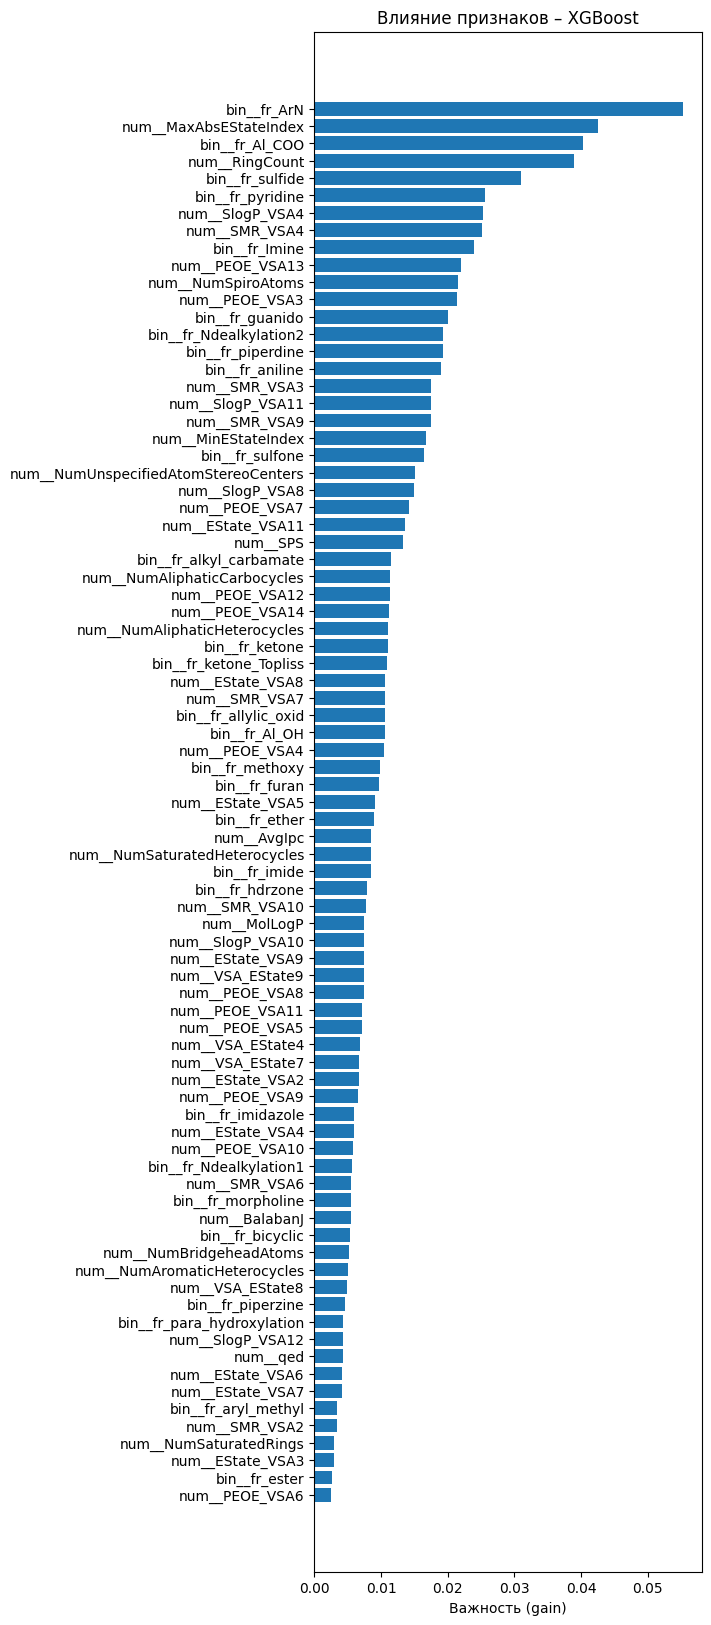

In [28]:
import matplotlib.pyplot as plt

def get_feature_names(pipeline, X):
    for _, step in pipeline.steps:
        if isinstance(step, ColumnTransformer):
            return step.get_feature_names_out()
    # если ColumnTransformer не найден
    return X.columns

# выводит диаграмму с важностями признаков
def plot_feature_importances(pipe, X):
    feature_names = get_feature_names(pipe, X)
    
    model = pipe[-1]
    importances = model.feature_importances_
    
    # 4. приводим к DataFrame и сортируем
    imp_df = (pd.DataFrame({"feature": feature_names, "importance": importances})
                .sort_values("importance", ascending=False))
    
    # 5. строим график
    plt.figure(figsize=(5, 20))
    plt.barh(imp_df["feature"], imp_df["importance"])
    plt.gca().invert_yaxis()  # самые важные сверху
    plt.xlabel("Важность (gain)")
    plt.title("Влияние признаков – XGBoost")
    # plt.tight_layout()
    plt.show()

plot_feature_importances(pipeline_xgb, X)

Модель для предсказания активности молекулы в отношении BACE готова. R2=0.7 достаточно чтобы оценить активность с неплохой точностью.

| Признак                          | Связь с BACE1                                                                                             |
| -------------------------------- | --------------------------------------------------------------------------------------------------------- |
| **bin\_\_fr\_ArN** (ароматич. N) | Прямое участие в солевых мостиках и π‑связывании. Типично для ингибиторов BACE1 (пиридины, анилины).   |
| **MaxAbsEStateIndex**            | Характеризует сильно активные атомы, т.е. потенциальные центры связывания.                             |
| **fr\_Al\_COO** (карбоксилы)     | Не всегда желательны — ионизированы при pH < 5, могут снижать проницаемость, но участвуют в связывании. |
| **RingCount**                    | Жёсткость структуры, характерная черта BACE1 ингибиторов.                                              |
| **fr\_pyridine**                 | Часто входит в фармакофорные мотивы; базовые атомы N связываются с Asp.                                |
| **fr\_sulfide**                  | Встречается в сульфонильных производных, может участвовать в связывании или менять метаболизм.         |
| **PEOE\_VSA13**                  | Показывает области с δ⁻ зарядом — критично для взаимодействия с Asp.                                      |
| **SMR\_VSA** и **SlogP\_VSA**    | Отражают поляризуемость и гидрофобность поверхности — важно для качества посадки в активный центр.        |


Модель:

акцентирует внимание на базовых N-группах, ароматике, полярности и реакционных центрах;

это согласуется с известными ингибиторами (например, β-аминопептидомиметики, пиримидины, пурины, гуанидины);

никаких странных артефактов в виде признаков, не имеющих отношения к связыванию или проницаемости, в топе не наблюдается.

# ACHE

### Импорт и обработка данных

In [29]:
df_ache = import_chembl(['ache.xlsx', 'ache_ki.xlsx'])
df3_ache = import_bdb('ache3.xlsx')
df_ache = pd.concat([df_ache, df3_ache], axis=0).reset_index(drop=True)
df_ache = handle_duplicates(df_ache)
df_ache = prepare_data(df_ache)
df_ache

,Smiles,pActivity,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,FpDensityMorgan1,AvgIpc,BalabanJ,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CCN(CC)C(C)CN1c2ccccc2Sc2ccccc21,3.761452,2.520809,0.527048,0.527048,0.765195,14.636364,0.909091,2.554878,1.958548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2,8.537602,12.936933,0.108783,0.108783,0.747461,20.214286,1.000000,3.033559,1.336255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Nc1c2c(nc3ccccc13)CCCC2,7.397940,6.199769,0.953981,0.953981,0.706488,15.200000,1.066667,2.295877,2.359120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c1ccc2c(NCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c(nc2c...,6.677781,4.973328,1.021859,1.021859,0.269986,15.085714,0.542857,2.910397,1.069899,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,c1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c(nc...,8.886057,4.975435,1.049444,1.049444,0.220114,14.918919,0.513514,2.948418,0.979479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14166,CN1CC[C@]2(C)c3cc(OC(=O)Nc4ccccc4)ccc3NC12,5.247606,12.084481,0.054920,-0.474677,0.885760,24.833333,1.291667,3.018833,1.526278,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14167,CNC(=O)Oc1ccc2c(c1)[C@@]1(C)CCN(C)C1N2,5.658862,11.283829,0.089429,-0.434121,0.808414,28.473684,1.578947,2.844930,1.943804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14168,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)C1N2C=O,6.411728,11.513197,0.028011,-0.494969,0.833702,27.190476,1.523810,2.909527,2.042070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14169,CN(CCOCCNC(=S)NC1CCCCC1)Cc1ccccc1,5.853872,5.690820,0.561393,0.561393,0.529495,15.416667,1.166667,2.595059,1.449486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Модель

In [33]:
# формируем Х и У, определяем количественные и бинарные признаки
y_ache = df_ache["pActivity"].values.astype(np.float32)
X_ache = df_ache.drop(columns=["Smiles", "pActivity"])
num_cols_ache, bin_cols_ache = split_features(X_ache)

In [35]:
# отбираем при помощи RFECV столбцы для прогнозирования активности AChE
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols_ache),
    ("bin", "passthrough",   bin_cols_ache)
])

base_estimator = XGBRegressor(random_state=seed)

rfecv = RFECV(
    estimator=base_estimator,
    step=1,
    min_features_to_select=5,
    cv=KFold(n_splits=5, shuffle=True, random_state=seed),
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

pipeline = Pipeline([
    ("prep", preprocess),
    ("fs",   rfecv)
])
pipeline.fit(X_ache, y_ache)

Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['MaxAbsEStateIndex',
                                                   'MinAbsEStateIndex',
                                                   'MinEStateIndex', 'qed',
                                                   'SPS', 'FpDensityMorgan1',
                                                   'AvgIpc', 'BalabanJ', 'Ipc',
                                                   'PEOE_VSA1', 'PEOE_VSA10',
                                                   'PEOE_VSA11', 'PEOE_VSA12',
                                                   'PEOE_VSA13', 'PEOE_VSA14',
                                                   'PEOE_VSA2', 'PEOE_VSA3',
                                                   'PEOE_VSA4', 'PEOE_VSA5',
                                                   'PEOE_VSA6', 'PEOE_VSA8',
                                                   'PEOE_...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...),
                       min_features_to_select=5, n_jobs=-1,
                       scoring='neg_mean_squared_error', verbose=1))])

In [36]:
mask_ache = pipeline.named_steps["fs"].support_
selected_features_ache = X_ache.columns[mask_ache]
print(f"Выбрано {len(selected_features_ache)} из {X_ache.shape[1]} признаков:")
print(selected_features_ache.to_list())

Выбрано 92 из 117 признаков:
['MaxAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'FpDensityMorgan1', 'AvgIpc', 'BalabanJ', 'Ipc', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA6', 'SMR_VSA9', 'SlogP_VSA10', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA7', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'NHOHCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAmideBonds', 'NumAromaticHeterocycles', 'NumHeterocycles', 'fr_Al_COO', 'fr_Al_OH', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_C_S', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_Ndealkylation2', 'fr_alkyl_carbamate', 'fr_allylic_oxid', 'fr_aniline', 'fr

In [37]:
X_ache = X_ache[selected_features_ache].copy()
num_cols_ache, bin_cols_ache = split_features(X_ache)
X_ache

,MaxAbsEStateIndex,MinEStateIndex,qed,SPS,FpDensityMorgan1,AvgIpc,BalabanJ,Ipc,PEOE_VSA1,PEOE_VSA10,...,fr_para_hydroxylation,fr_phos_acid,fr_piperzine,fr_priamide,fr_quatN,fr_sulfide,fr_sulfonamd,fr_term_acetylene,fr_unbrch_alkane,fr_urea
0,2.520809,0.527048,0.765195,14.636364,0.909091,2.554878,1.958548,1.398029e+05,4.899910,0.000000,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.936933,0.108783,0.747461,20.214286,1.000000,3.033559,1.336255,3.746810e+06,9.473726,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.199769,0.953981,0.706488,15.200000,1.066667,2.295877,2.359120,4.959094e+03,5.733667,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.973328,1.021859,0.269986,15.085714,0.542857,2.910397,1.069899,2.172599e+08,10.633577,0.000000,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,4.975435,1.049444,0.220114,14.918919,0.513514,2.948418,0.979479,5.762293e+08,10.633577,0.000000,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14166,12.084481,-0.474677,0.885760,24.833333,1.291667,3.018833,1.526278,4.654316e+05,10.053652,5.749512,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14167,11.283829,-0.434121,0.808414,28.473684,1.578947,2.844930,1.943804,2.936821e+04,15.370440,5.749512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14168,11.513197,-0.494969,0.833702,27.190476,1.523810,2.909527,2.042070,7.460900e+04,10.053652,5.749512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14169,5.690820,0.561393,0.529495,15.416667,1.166667,2.595059,1.449486,2.933869e+05,15.370440,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# готовим XGB пайплайн

transformer_ache = ColumnTransformer([
    ("num", StandardScaler(), num_cols_ache),
    ("bin", "passthrough", bin_cols_ache)
    ],
    remainder="drop"
)

pipeline_xgb_ache = Pipeline([("prep", transformer_ache),
                            ("xgb", XGBRegressor(
                                n_estimators=50,
                                max_depth=6,
                                eta=0.25,
                                random_state=seed
                                ))]
                        )

learning("XGBoost", pipeline_xgb_ache, X_ache, y_ache)

XGBoost fold 1: RMSE=0.7467, time=0.1s
XGBoost fold 2: RMSE=0.7450, time=0.1s
XGBoost fold 3: RMSE=0.7236, time=0.1s
XGBoost fold 4: RMSE=0.7215, time=0.1s
XGBoost fold 5: RMSE=0.7622, time=0.1s

=== XGBoost ===
MAE: 0.5300 ± 0.0056
RMSE: 0.7398 ± 0.0153
R2: 0.7768 ± 0.0088
Time: 0.1247 ± 0.0027


In [39]:
# обучаем модель на всех данных
pipeline_xgb_ache.fit(X_ache, y_ache)
preds = pipeline_xgb_ache.predict(X_ache)
scores = []
scores.append({
    "MAE":  mean_absolute_error(y_ache, preds),
    "RMSE": rms_error(y_ache, preds),
    "R2":   r2_score(y_ache, preds),
    "Time": 0
})
cv_report('xgb_ache', scores)


=== xgb_ache ===
MAE: 0.4255 ± 0.0000
RMSE: 0.5824 ± 0.0000
R2: 0.8618 ± 0.0000
Time: 0.0000 ± 0.0000


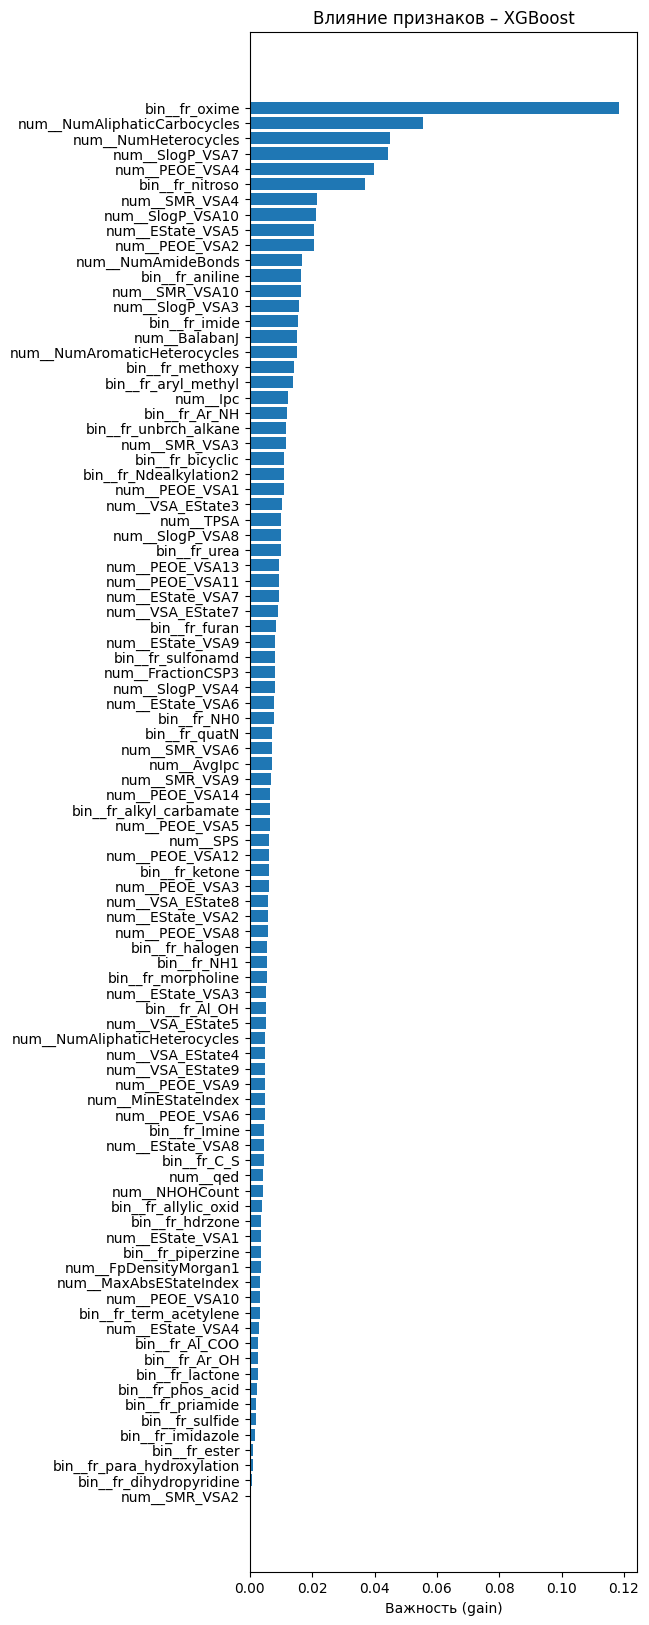

In [40]:
plot_feature_importances(pipeline_xgb_ache, X_ache)

Здесь результат по метрикам ещё лучше чем в BACE, хотя данных меньше. Качество модель также достаточно чтобы оценить активность сгенерированных молекул

| Признак                     | Связь с AChE                                                                                                                                       |
| --------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------- |
| **bin\_\_fr\_oxime**        | Оксимы (–C=NOH) входят в структуру реактиваторов AChE (например, пралидоксим). Формируют прочные H‑связи в каталитическом триаде (Ser-His-Glu). |
| **NumAliphaticCarbocycles** | Повышают жёсткость структуры и гидрофобность — важны для посадки в **гидрофобный тоннель** AChE.                                                |
| **NumHeterocycles**         | Ароматические гетероциклы часто участвуют в π‑связывании с Trp86, Phe338 и др. остатками.                                                       |
| **SlogP\_VSA7**             | Умеренно гидрофобная поверхность — хорошо ложится в периферийный сайт связывания (PAS).                                                         |
| **PEOE\_VSA4**              | Умеренно положительно заряженные атомы (чаще всего азоты) — взаимодействуют с карбоксильными группами Glu, Asp.                                  |
| **bin\_\_fr\_nitroso**      | Может участвовать в H‑связях или окислительно‑восстановительных взаимодействиях, но также маркер токсичности.                                   |
| **SMR\_VSA4**               | Поляризуемая область — важна для непрямых ван‑дер‑ваальсовых взаимодействий в глубоком сайте.                                                   |
| **SlogP\_VSA10**            | Обширная гидрофобная поверхность — позволяет молекуле "заполнить" активный сайт и блокировать фермент.                                          |

Модель делает акцент на:

оксимы и гетероциклы — типично для ингибиторов и реактиваторов;

заряженные и полярные участки — для взаимодействия с триадой Ser-His-Glu и периферийным сайтом PAS;

жёсткие и умеренно гидрофобные каркасы — оптимальны для посадки в глубокую и узкую активную щель фермента.

Это согласуется с известными структурами, такими как такрин, галантамин, донепезил, и особенно с производными пиридиния и оксимов в контексте реактиваторов.

# Генерируем и оцениваем молекулы

## Дипсик

In [299]:
# ---------- вводные ----------
k        = 5          # количество соседей, как в ADChecker
radius   = 2          # ECFP4 → радиус 2
fp_bits  = 2048
percentiles = [1, 5, 10]   # какие пороги хотите получить

# ---------- подготовка отпечатков ----------
smiles_list = df['Smiles'].dropna().astype(str)
use_new_api = tuple(map(int, rdBase.rdkitVersion.split('.'))) >= (2023, 9, 0)
if use_new_api:
    gen = rdFingerprintGenerator.GetMorganGenerator(
        radius=radius, fpSize=fp_bits, countSimulation=False)
    fps = [gen.GetFingerprint(Chem.MolFromSmiles(s))
           for s in smiles_list if Chem.MolFromSmiles(s)]
else:
    fps = [AllChem.GetMorganFingerprintAsBitVect(
           Chem.MolFromSmiles(s), radius, nBits=fp_bits)
           for s in smiles_list if Chem.MolFromSmiles(s)]

# ---------- вычисление медианы k-NN Tanimoto ----------
med_sims = []
for fp in fps:
    sims = sorted(DataStructs.BulkTanimotoSimilarity(fp, fps), reverse=True)[1:k+1]
    med_sims.append(np.median(sims))

# ---------- сами пороги ----------
thresholds = {f"p{p}": float(np.percentile(med_sims, p)) for p in percentiles}
print(thresholds)

{'p1': 0.39375527426160334, 'p5': 0.6376811594202898, 'p10': 0.6984126984126984}


In [38]:
# модели из рекомендованного списка очень долго не могли запуститься, попробуем дипсик))

DEEPSEEK_API_KEY = 'sk-6362250e9df941ec90a3cb3488184a0a'
MODEL_NAME       = "deepseek-chat"
MAX_TOKENS       = 8192
TEMPERATURE      = 0.9

# -------------------------- низкоуровневый вызов -------------------------- #
def _call_deepseek_with_retry(prompt_content,
                              system_instruction,
                              max_tokens = MAX_TOKENS,
                              temperature = TEMPERATURE,
                              model = MODEL_NAME,
                              api_key = DEEPSEEK_API_KEY):

    client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user",   "content": prompt_content},
    ]
    rsp = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
        response_format={"type": "text"},
    )
    return rsp.choices[0].message.content.strip()

def generate_smiles_deepseek(n_samples, api_key = DEEPSEEK_API_KEY, **kwargs):
    system_msg = (
        "Ты — опытный медхимик. Генерируй только валидные канонические SMILES "
        "малых лекарственно-подобных молекул, потенциально ингибирующих BACE1 и AchE. "
        "Никаких пояснений, только SMILES. "
        # f"Структурно они должны быть похожи на {str(df['Smiles'].sample(n=1000))+str(df_ache['Smiles'].sample(n=1000))}"
    )
    user_msg   = f"Сгенерируй {n_samples} уникальных SMILES. Один SMILES = одна строка."
    raw = _call_deepseek_with_retry(
        prompt_content=user_msg,
        system_instruction=system_msg,
        api_key=DEEPSEEK_API_KEY,
        **kwargs
    )
    smiles_list = [ln.strip() for ln in raw.splitlines() if ln.strip()]
    smiles_unique = list(dict.fromkeys(smiles_list))
    return smiles_unique

In [39]:
raw_smiles = generate_smiles_deepseek(50)
for s in raw_smiles:
    print(s)

O=C(Nc1ccc(cc1)C(=O)N2CCCC2)c3ccccc3
CN1CCN(CC1)C(=O)c2cc(OC)c(OC)cc2OC
CC(=O)Nc1ccc(cc1)C(=O)N2CCOCC2
O=C(Nc1ccccc1)C(=O)N2CCC(CC2)c3ccccc3
CN(C)C(=O)c1cc(OC)c(OC)cc1OC
CCN(CC)C(=O)c1ccccc1Br
O=C(Nc1ccccc1F)C(=O)N2CCCC2
CN1CCN(CC1)C(=O)c2ccccc2Cl
CC(=O)Nc1ccc(cc1)C(=O)N2CCCC2
O=C(Nc1ccccc1)C(=O)N2CCCC2C
CN(C)C(=O)c1ccccc1F
CCN(CC)C(=O)c1ccccc1I
O=C(Nc1ccccc1Cl)C(=O)N2CCCC2
CN1CCN(CC1)C(=O)c2ccccc2Br
O=C(Nc1ccccc1)C(=O)N2CCC(CC2)C
CN(C)C(=O)c1ccccc1I
CCN(CC)C(=O)c1ccccc1Cl
O=C(Nc1ccccc1Br)C(=O)N2CCCC2
CN1CCN(CC1)C(=O)c2ccccc2F
CC(=O)Nc1ccc(cc1)C(=O)N2CCNCC2
O=C(Nc1ccccc1)C(=O)N2CCCC2O
CN(C)C(=O)c1ccccc1Br
CCN(CC)C(=O)c1ccccc1F
O=C(Nc1ccccc1I)C(=O)N2CCCC2
CC(=O)Nc1ccc(cc1)C(=O)N2CCN(CC2)C
O=C(Nc1ccccc1)C(=O)N2CCCC2S
CN(C)C(=O)c1ccccc1Cl
CN1CCN(CC1)C(=O)c2ccccc2I
CC(=O)Nc1ccc(cc1)C(=O)N2CC(O)CC2
O=C(Nc1ccccc1)C(=O)N2CCCC2N


In [162]:
def is_valid_smiles(smi: str):
    return Chem.MolFromSmiles(smi) is not None

def calculate_descriptors(mol: Chem.Mol) -> dict:
    d = {}
    desc_names = [name for name, _ in Descriptors.descList]
    for name in desc_names:
        if hasattr(Descriptors, name):
            d[name] = getattr(Descriptors, name)(mol)
        elif name.startswith("fr_"):
            d[name] = getattr(Descriptors, name)(mol)
    return d

def lipinski_violations(mol: Chem.Mol) -> int:
    v = 0
    if Descriptors.MolWt(mol) > 500:           v += 1
    if Lipinski.NumHDonors(mol) > 5:           v += 1
    if Lipinski.NumHAcceptors(mol) > 10:       v += 1
    if Crippen.MolLogP(mol) > 5:               v += 1
    return v

def evaluate_molecules(raw_smiles, cols, model):
    params = FilterCatalog.FilterCatalogParams()
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.BRENK)
    brenk_catalog = FilterCatalog.FilterCatalog(params)
    has_tox = lambda m: brenk_catalog.HasMatch(m)
    
    # ---------- основной цикл ---------------------------------------------------
    records = []
    for smi in raw_smiles:
        if not is_valid_smiles(smi):
            continue
        mol = Chem.MolFromSmiles(smi)
        desc = calculate_descriptors(mol)
        if any(pd.isna(list(desc.values()))):
            continue
        desc["QED"]            = QED.qed(mol)
        desc["SA"]             = sascorer.calculateScore(mol)   # ← SA-Score
        desc["Lipinski_viol"]  = lipinski_violations(mol)
        desc["Tox"]            = has_tox(mol)
        desc["Smiles"]         = smi
        records.append(desc)
    
    df_gen = pd.DataFrame(records)
    print(f"Валидных молекул: {len(df_gen)}")
    
    # предсказание активности
    df_gen["pActivity_pred"] = model.predict(df_gen[cols])
    return df_gen

df_res_bace = evaluate_molecules(raw_smiles, selected_features, pipeline_xgb)
df_res_ache = evaluate_molecules(raw_smiles, selected_features_ache, pipeline_xgb_ache)

# финальный датасет с молекулами
df_gen = pd.DataFrame()
for col in ['Smiles', 'QED', 'SA', 'Lipinski_viol', 'Tox']:
    df_gen[col] = df_res_bace[col]
df_gen['pActivity_pred_bace1'] = df_res_bace['pActivity_pred']
df_gen['pActivity_pred_ache'] = df_res_ache['pActivity_pred']
df_gen

Валидных молекул: 30
Валидных молекул: 30


,Smiles,QED,SA,Lipinski_viol,Tox,pActivity_pred_bace1,pActivity_pred_ache
0,O=C(Nc1ccc(cc1)C(=O)N2CCCC2)c3ccccc3,0.944900,1.459705,0,False,5.828887,6.091188
1,CN1CCN(CC1)C(=O)c2cc(OC)c(OC)cc2OC,0.832140,1.833230,0,False,4.952735,4.768195
2,CC(=O)Nc1ccc(cc1)C(=O)N2CCOCC2,0.852792,1.628631,0,False,4.411234,5.742325
3,O=C(Nc1ccccc1)C(=O)N2CCC(CC2)c3ccccc3,0.867007,1.798664,0,True,5.305682,5.410570
4,CN(C)C(=O)c1cc(OC)c(OC)cc1OC,0.796810,1.764873,0,False,5.361158,6.278317
5,CCN(CC)C(=O)c1ccccc1Br,0.813754,1.727665,0,False,5.003790,4.471630
6,O=C(Nc1ccccc1F)C(=O)N2CCCC2,0.748905,1.784827,0,True,3.514857,6.271776
7,CN1CCN(CC1)C(=O)c2ccccc2Cl,0.744101,1.587828,0,False,4.860910,5.141279
8,CC(=O)Nc1ccc(cc1)C(=O)N2CCCC2,0.845993,1.495186,0,False,5.596887,5.573878
9,O=C(Nc1ccccc1)C(=O)N2CCCC2C,0.748164,2.275836,0,True,3.284353,5.373489


In [163]:
from rdkit import Chem, DataStructs, rdBase
from rdkit.Chem import rdFingerprintGenerator

class ADChecker:
    """
    Проверка области применимости (AD) по k-NN-Танимото.
    """
    def __init__(self, train_smis, radius=2, nBits=2048,
                 k=5, sim_threshold=0.4):
        self.radius, self.nBits = radius, nBits
        self.k, self.t = k, sim_threshold

        # определяем, доступен ли новый генератор
        self._use_new_api = tuple(map(int, rdBase.rdkitVersion.split('.'))) >= (2023, 9, 0)
        if self._use_new_api:
            self.gen = rdFingerprintGenerator.GetMorganGenerator(
                radius=radius,
                fpSize=nBits,
                countSimulation=False,
            )

        # подготовка обучающего набора
        self.train_fp = []
        for s in train_smis:
            mol = Chem.MolFromSmiles(str(s))
            if mol is None:
                continue
            fp = self._mol2fp(mol)
            self.train_fp.append(fp)

    def _mol2fp(self, mol):
        """Преобразуем Mol → отпечаток нужным способом"""
        if self._use_new_api:
            return self.gen.GetFingerprint(mol)

    def _topk_sims(self, fp):
        sims = DataStructs.BulkTanimotoSimilarity(fp, self.train_fp)
        return sorted(sims, reverse=True)[: self.k]

    def check(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {"status": "invalid_smiles"}

        fp = self._mol2fp(mol)
        s_med = float(np.median(self._topk_sims(fp)))

        if s_med >= self.t:
            status = "inside_AD"
        elif s_med < self.t / 2:
            status = "outside_AD"
        else:
            status = "borderline"
        return {"status": status, "median_sim": s_med}

def is_inside(smiles: str) -> bool:
    """True, если молекула внутри AD, иначе False."""
    return checker.check(smiles)["status"] == "inside_AD"

train_smiles = df["Smiles"].tolist()
checker = ADChecker(train_smiles, k=5, sim_threshold=0.4)
df_gen["in_AD"] = df_gen["Smiles"].astype(str).apply(is_inside)

train_smiles = df_ache["Smiles"].tolist()
checker = ADChecker(train_smiles, k=5, sim_threshold=0.4)
df_gen["in_AD_ache"] = df_gen["Smiles"].astype(str).apply(is_inside)

In [164]:
def esol_logS(mw, logp, rotb, ap):
    """ESOL (Delaney 2004) logS, в M (log10).  ap = ароматическая доля атомов."""
    return 0.46 - 0.63*logp - 0.0062*mw + 0.066*rotb - 0.74*ap

def calc_adme_descriptors(smi: str):
    """Расширенный ADME/BBB-пакет.  Возвращает серию из 15 полей."""
    mol = Chem.MolFromSmiles(str(smi))
    if mol is None:
        return pd.Series([None]*15,
            index=['cLogP','TPSA','MW','HBD','HBA','RotB','Fsp3',
                   'logS','absorp_ok','logBB','BBB_pred',
                   'pgp_risk','cyp_alert','adme_flag','all_ok'])
    
    # —–– базовые RDKit-дескрипторы –––
    logp  = Crippen.MolLogP(mol)
    tpsa  = rdMolDescriptors.CalcTPSA(mol)
    mw    = Descriptors.MolWt(mol)
    hbd   = Lipinski.NumHDonors(mol)
    hba   = Lipinski.NumHAcceptors(mol)
    rotb  = Descriptors.NumRotatableBonds(mol)
    fsp3  = rdMolDescriptors.CalcFractionCSP3(mol)
    
    # ароматическая доля атомов (для ESOL)
    arom_atoms = sum(1 for a in mol.GetAromaticAtoms())
    ap = arom_atoms / mol.GetNumAtoms()
    
    # —–– «A» : растворимость ESOL –––
    logS = esol_logS(mw, logp, rotb, ap)
    absorp_ok = (logS >= -5) and (1 <= logp <= 4) and (hba <= 8) and (rotb <= 8)
    
    # —–– «D» : BBB –––
    logBB = 0.152*logp - 0.0148*tpsa + 0.139        # Clark
    bbb_ok = (tpsa < 90) and (hbd <= 3) and (mw <= 450) and (logBB > -0.3)
    
    # —–– efflux / метаболизм риски (грубые) –––
    pgp_risk  = (tpsa > 90) or (hbd > 3) or (logp < 1)
    smarts_alerts = ['[NX3;H2,H1;!$(NC=O)]', 'c1ccccc1[N+](=O)[O-]', 'C=C-C']  # анилин, нитро-арил, аллил
    cyp_alert = any(mol.HasSubstructMatch(Chem.MolFromSmarts(s)) for s in smarts_alerts)
    
    # сводный флаг
    adme_flag = absorp_ok and not pgp_risk and not cyp_alert
    all_ok    = adme_flag and bbb_ok
    
    return pd.Series([logp, tpsa, mw, hbd, hba, rotb, fsp3,
                      logS, absorp_ok, logBB, bbb_ok,
                      pgp_risk, cyp_alert, adme_flag, all_ok],
         index=['cLogP','TPSA','MW','HBD','HBA','RotB','Fsp3',
                'logS','absorp_ok','logBB','BBB_pred',
                'pgp_risk','cyp_alert','adme_flag','all_ok'])

df_gen[[
    'cLogP','TPSA','MW','HBD','HBA','RotB','Fsp3',
    'logS','absorp_ok','logBB','BBB_pred',
    'pgp_risk','cyp_alert','adme_flag','all_ok'
]] = df_gen['Smiles'].apply(calc_adme_descriptors)

In [165]:
# ==== 1. PAINS ====
params = FilterCatalog.FilterCatalogParams()
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS_A)
pains_catalog = FilterCatalog.FilterCatalog(params)

def has_pains(mol):          # True, если триггернут ≥1 подструктура
    return pains_catalog.HasMatch(mol)

# ==== 2. hERG «выстрелы» по простым SMARTS ====
smarts_hERG = [
    '[c,n,o]1cc(c[n,o]1)C#N',      # арил-nitrile (Kv-alert)
    'c1ccc(cc1)C(=O)N'             # пара-аминобензамид
]
hERG_motifs = [Chem.MolFromSmarts(s) for s in smarts_hERG]
def herg_alert(mol):
    return any(mol.HasSubstructMatch(pat) for pat in hERG_motifs)

# ==== 3. pKa(approx) & logD7.4 через простое правило Черчилля-Tippets ====
def pKa_basic(mol):
    # число амино азотов + коррекция на электроноакцепторы
    bas_n = sum(1 for a in mol.GetAtoms()
                if a.GetAtomicNum()==7 and a.GetTotalDegree()==3 and a.GetFormalCharge()==0)
    return 9.5 - 1.2*(bas_n-1) if bas_n else None

def logD74(clogp, pka):
    if pka is None:
        return clogp
    alpha = 1 / (1 + 10**(7.4 - pka))    # степень ионизации
    return clogp + np.log10(alpha)

# ==== агрегатор, вызывается для каждой строки ====
def extra_flags(smi):
    mol = Chem.MolFromSmiles(str(smi))
    if mol is None:
        return pd.Series([None]*4, index=['pKa','logD74','PAINS','hERG_alert'])
    clogp = Crippen.MolLogP(mol)
    pka   = pKa_basic(mol)
    return pd.Series([
        pka,
        logD74(clogp, pka),
        has_pains(mol),
        herg_alert(mol)
    ], index=['pKa','logD74','PAINS','hERG_alert'])

df_gen[['pKa','logD74','PAINS','hERG_alert']] = df_gen['Smiles'].apply(extra_flags)

In [166]:
# формируем итоговый список молекул

mask = (
    (df_gen["in_AD"]) & 
    (df_gen["pActivity_pred_bace1"] > 5) &
    (df_gen["pActivity_pred_ache"] > 5) &
    (df_gen["QED"] > 0.6) &
    (df_gen["SA"] < 6.0) &
    (df_gen["Lipinski_viol"] <= 1) &
    (~df_gen["Tox"]) &
    (df_gen["all_ok"] == True)
)

hits = (df_gen.loc[mask]
        .sort_values(["pActivity_pred_bace1", "pActivity_pred_ache"], ascending=False)
        .reset_index(drop=True))

print(f"Финальных хитов: {len(hits)}")
hits['Smiles'] = hits['Smiles'].map(canonize)
hits[["Smiles", "SA", "pActivity_pred_bace1", "pActivity_pred_ache", "QED", 'cLogP','TPSA','MW','logS','BBB_pred','absorp_ok','pgp_risk','cyp_alert','all_ok', 'pKa','logD74','PAINS','hERG_alert','in_AD','in_AD_ache']]

Финальных хитов: 1


,Smiles,SA,pActivity_pred_bace1,pActivity_pred_ache,QED,cLogP,TPSA,MW,logS,BBB_pred,absorp_ok,pgp_risk,cyp_alert,all_ok,pKa,logD74,PAINS,hERG_alert,in_AD,in_AD_ache
0,O=C(Nc1ccc(C(=O)N2CCCC2)cc1)c1ccccc1,1.459705,5.828887,6.091188,0.9449,3.1749,49.41,294.354,-3.570818,True,True,False,False,True,8.3,3.123403,False,True,True,True


In [168]:
# проверяем, не взяла ли модель просто молекулу из датасета)
hits_valid = hits.dropna(subset=['Smiles'])
df_valid   = df.dropna(subset=['Smiles'])

intersect = set(hits_valid['Smiles']) & set(df_valid['Smiles'])

print(f'Совпадающих молекул: {len(intersect)}')
hits_in_df = hits_valid[hits_valid['Smiles'].isin(intersect)]

Совпадающих молекул: 0


## reinvent4

In [183]:
from pathlib import Path, PurePath
import subprocess, json, tomli_w

sampling_cfg = {
    "run_type": "sampling",
    "device":   "cuda:0",
    "parameters": {
        "model_file":       str("reinvent.prior"),
        "sample_strategy":  "multinomial",
        "num_smiles":       5000,
        "unique_molecules": True,
        "output_file":      str("bace1_generated_4.txt")
    }
}

with open("sampling.toml", "wb") as f:
    tomli_w.dump(sampling_cfg, f)

result = subprocess.run(
    ["reinvent", "-l", "sample.log", "sampling.toml"],
    capture_output=True, text=True
)

print("STDERR:\n", result.stderr)
print("STDOUT:\n", result.stdout)


STDERR:
 
STDOUT:
 


In [174]:
from pathlib import Path

def load_smiles(path: str | Path) -> list[str]:
    """Читает файл <SMILES,значение> и возвращает список SMILES."""
    with open(path, encoding="utf-8") as f:
        smiles_list = [
            line.split(",")[0].strip()          # берём всё до первой запятой
            for line in f
            if line.strip()                     # пропускаем пустые строки
        ]
    return smiles_list


# пример использования
smiles = load_smiles("bace1_generated_3.txt")
print(f"Загружено {len(smiles)} SMILES:")
print(smiles[:5])  # вывели первые 5 для проверки


Загружено 49155 SMILES:
['SMILES', 'O=c1oc2cc(O)ccc2cc1-c1ccc(O)c(CO)c1', 'CC(C)(C)c1nc(C2CCCN2C(=O)Nc2ccc(C#N)cc2)no1', 'N=C(N)c1ccc2cc(OCCCCCOc3c(Cl)cc(Oc4ccncc4F)cc3Br)c(C(F)(F)F)cc2c1', 'Cn1c(O)c2ccc(O)c(C(O)Nc3ccc(F)cc3)c2c1O']


In [175]:
df_res_bace = evaluate_molecules(smiles, selected_features, pipeline_xgb)
df_res_ache = evaluate_molecules(smiles, selected_features_ache, pipeline_xgb_ache)

# финальный датасет с молекулами
df_gen = pd.DataFrame()
for col in ['Smiles', 'QED', 'SA', 'Lipinski_viol', 'Tox']:
    df_gen[col] = df_res_bace[col]
df_gen['pActivity_pred_bace1'] = df_res_bace['pActivity_pred']
df_gen['pActivity_pred_ache'] = df_res_ache['pActivity_pred']
df_gen

[17:13:35] SMILES Parse Error: syntax error while parsing: SMILES
[17:13:35] SMILES Parse Error: check for mistakes around position 2:
[17:13:35] SMILES
[17:13:35] ~^
[17:13:35] SMILES Parse Error: Failed parsing SMILES 'SMILES' for input: 'SMILES'


Валидных молекул: 49154


[17:20:33] SMILES Parse Error: syntax error while parsing: SMILES
[17:20:33] SMILES Parse Error: check for mistakes around position 2:
[17:20:33] SMILES
[17:20:33] ~^
[17:20:33] SMILES Parse Error: Failed parsing SMILES 'SMILES' for input: 'SMILES'


Валидных молекул: 49154


,Smiles,QED,SA,Lipinski_viol,Tox,pActivity_pred_bace1,pActivity_pred_ache
0,O=c1oc2cc(O)ccc2cc1-c1ccc(O)c(CO)c1,0.628347,2.267625,0,True,4.861321,4.374540
1,CC(C)(C)c1nc(C2CCCN2C(=O)Nc2ccc(C#N)cc2)no1,0.901555,2.954796,0,False,5.736534,5.486306
2,N=C(N)c1ccc2cc(OCCCCCOc3c(Cl)cc(Oc4ccncc4F)cc3...,0.074254,2.940446,2,True,6.251759,7.085877
3,Cn1c(O)c2ccc(O)c(C(O)Nc3ccc(F)cc3)c2c1O,0.478132,3.320654,0,True,5.067601,4.348450
4,Cc1cccc(N=c2cc[nH]c(=NCc3cccnc3Cl)[nH]2)c1,0.713944,3.382023,0,True,4.795640,4.762446
...,...,...,...,...,...,...,...
49149,COc1ccc(C[S+]([O-])c2ccc3[nH]c4c(c3c2)CCC(C)C4...,0.696424,3.731777,0,True,6.100522,5.998766
49150,CN(C(=O)c1ccccc1)C1CCC2CNC(C(=O)O)CC2C1,0.894593,3.474408,0,False,4.837200,5.369717
49151,Clc1ccc(OC2CCN(Cc3ccc4ncccc4c3)CC2)cc1,0.665197,1.962879,0,False,5.969275,6.198462
49152,CC(CNC(=O)NCC1CCNCC1)Cc1cccc(C(=N)N)c1,0.385782,2.891688,0,True,5.438774,6.225698


In [176]:
# смотрим надежна ли оценка активности по AD чекеру
train_smiles = df["Smiles"].tolist()
checker = ADChecker(train_smiles, k=5, sim_threshold=0.4)
df_gen["in_AD"] = df_gen["Smiles"].astype(str).apply(is_inside)

train_smiles = df_ache["Smiles"].tolist()
checker = ADChecker(train_smiles, k=5, sim_threshold=0.4)
df_gen["in_AD_ache"] = df_gen["Smiles"].astype(str).apply(is_inside)

# считаем метрики
df_gen[[
    'cLogP','TPSA','MW','HBD','HBA','RotB','Fsp3',
    'logS','absorp_ok','logBB','BBB_pred',
    'pgp_risk','cyp_alert','adme_flag','all_ok'
]] = df_gen['Smiles'].apply(calc_adme_descriptors)

df_gen[['pKa','logD74','PAINS','hERG_alert']] = df_gen['Smiles'].apply(extra_flags)

# формируем итоговый список молекул
mask = (
    (df_gen["in_AD"]) & 
    (df_gen["in_AD_ache"]) & 
    (df_gen["pActivity_pred_bace1"] > 5) &
    (df_gen["pActivity_pred_ache"] > 5) &
    (df_gen["QED"] > 0.6) &
    (df_gen["SA"] < 6.0) &
    (df_gen["Lipinski_viol"] <= 1) &
    (~df_gen["Tox"]) &
    (df_gen["all_ok"]) &
    (~df_gen["PAINS"])
)

hits = (df_gen.loc[mask]
        .sort_values(["pActivity_pred_bace1", "pActivity_pred_ache"], ascending=False)
        .reset_index(drop=True))

print(f"Финальных хитов: {len(hits)}")
hits['Smiles'] = hits['Smiles'].map(canonize)
hits[["Smiles", "SA", "pActivity_pred_bace1", "pActivity_pred_ache", "QED", 'cLogP','TPSA','MW','logS','BBB_pred','absorp_ok','pgp_risk','cyp_alert','all_ok', 'pKa','logD74','PAINS','hERG_alert','in_AD', 'in_AD_ache']]

Финальных хитов: 51


,Smiles,SA,pActivity_pred_bace1,pActivity_pred_ache,QED,cLogP,TPSA,MW,logS,BBB_pred,absorp_ok,pgp_risk,cyp_alert,all_ok,pKa,logD74,PAINS,hERG_alert,in_AD,in_AD_ache
0,O=C(c1ccccc1Br)N1CCN(c2ccccn2)CC1,1.820682,6.548041,5.365976,0.839134,2.80650,36.44,346.228,-3.745566,True,True,False,False,True,8.3,2.755003,False,True,True,True
1,COc1ccccc1C(=O)Nc1ccc(CN2CCCCC2)cc1,1.609146,6.446562,5.942436,0.905754,3.93340,41.57,324.424,-4.069471,True,True,False,False,True,8.3,3.881903,False,True,True,True
2,Cc1ccc(CNC(=O)CN(c2ccc(C)cc2)S(=O)(=O)c2ccccc2...,1.877789,6.252248,6.148772,0.646373,3.81514,66.48,408.523,-4.473691,True,True,False,False,True,8.3,3.763643,False,False,True,True
3,O=C1c2ccccc2CN1c1ccc(OCCN2CCCC2)cc1,1.969238,6.217997,6.545177,0.846407,3.32160,32.78,322.408,-3.671538,True,True,False,False,True,8.3,3.270103,False,True,True,True
4,Cc1ccc(OCC(=O)NC2CCN(Cc3ccccc3)CC2)cc1,1.704572,6.169390,5.360859,0.879617,3.15462,41.57,338.451,-3.585007,True,True,False,False,True,8.3,3.103123,False,False,True,True
5,O=S(=O)(c1ccccc1)N1CC2CCCN(Cc3ccccc3)CC2C1,2.695559,6.163116,6.601945,0.829692,3.21930,40.62,370.518,-3.942909,True,True,False,False,True,8.3,3.167803,False,False,True,True
6,Cc1ccc(NC(=O)C2CCN(C(=O)Cc3ccccc3)CC2)cc1C,1.765111,6.139833,6.205087,0.913451,3.72324,49.41,350.462,-4.136044,True,True,False,False,True,8.3,3.671743,False,False,True,True
7,COc1cc(C=Cc2cn(-c3ccccc3)nn2)ccc1O,2.230702,6.125568,5.591352,0.802434,3.15190,60.17,293.326,-3.652136,True,True,False,False,True,9.5,3.148464,False,False,True,True
8,Cc1ccccc1OCCN1CCN(c2ccccn2)CC1,1.811742,6.043312,5.092200,0.847966,2.59102,28.60,297.402,-3.089871,True,True,False,False,True,8.3,2.539523,False,False,True,True
9,COc1cccc(CN2CCC(C(=O)NCc3ccc(F)c(F)c3)CC2)c1OC,2.048367,6.038239,5.805189,0.767439,3.51040,50.80,404.457,-4.103392,True,True,False,False,True,8.3,3.458903,False,False,True,True


In [178]:
# проверяем, не взяла ли модель просто молекулу из датасета)
hits_valid = hits.dropna(subset=['Smiles'])
df_valid   = df.dropna(subset=['Smiles'])

intersect = set(hits_valid['Smiles']) & set(df_valid['Smiles'])

print(f'Совпадающих молекул: {len(intersect)}')
hits_in_df = hits_valid[hits_valid['Smiles'].isin(intersect)]

Совпадающих молекул: 0


# Докинг

In [114]:
# Ячейка 1: Импорты (все необходимые)
from pathlib import Path
import requests
from Bio.PDB import PDBParser, Select, PDBIO
from rdkit import Chem
from rdkit.Chem import AllChem
from meeko import MoleculePreparation, PDBQTMolecule  # Для подготовки лиганда и рецептора
import subprocess
import shlex
import textwrap
import os
import stat
import numpy as np  # Для расчёта центра масс

# Ячейка 2: Скачивание и очистка PDB для AChE и BACE1
# 4EY7
pdb_id = "1W51"
pdb_fn = Path(f"{pdb_id}.pdb")

if not pdb_fn.exists():
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    print("Downloading", url)
    pdb_fn.write_bytes(requests.get(url, timeout=30).content)

class KeepProtein(Select):
    def accept_residue(self, res):
        return res.id[0] == " "  # Оставляем только стандартные аминокислоты

parser = PDBParser(QUIET=True)
structure = parser.get_structure(pdb_id, pdb_fn)
io = PDBIO()
io.set_structure(structure)
clean_pdb = "4ey7_prot.pdb"
io.save(clean_pdb, KeepProtein())
print("Clean PDB saved →", clean_pdb)

# Ячейка 3: Подготовка рецептора в PDBQT с помощью OpenBabel (лучше для белков)
import subprocess

# Конвертируем очищенный PDB в PDBQT
# -xr: делает рецептор rigid (стандарт для Vina)
# -h: добавляет explicit Hs (решает вашу ошибку)
# -p 7: протонация при pH=7 (можно изменить)
cmd = [
    "obabel",
    "-ipdb", clean_pdb,
    "-opdbqt", "-O", "receptor.pdbqt",
    "-xr", "-h", "-p", "7"
]

proc = subprocess.run(cmd,
                      stdout=subprocess.PIPE,
                      stderr=subprocess.PIPE,
                      text=True)

print("STDOUT:\n", proc.stdout)
print("STDERR:\n", proc.stderr)
if proc.returncode == 0:
    print("Receptor prepared → receptor.pdbqt")
else:
    raise RuntimeError("OpenBabel failed! Check STDERR above.")

# Альтернатива: Если Meeko не сработает для рецептора, установите OpenBabel (pip install openbabel)
# и используйте: subprocess.run(["obabel", "-ipdb", clean_pdb, "-opdbqt", "-O", "receptor.pdbqt", "-xr"])

# Ячейка 4: Подготовка лиганда
smi = "O=C(Nc1ccc(C(=O)N2CCCC2)cc1)c1ccccc1"
mol = Chem.AddHs(Chem.MolFromSmiles(smi))
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.MMFFOptimizeMolecule(mol)

prep = MoleculePreparation()
prep.prepare(mol)
prep.write_pdbqt_file("ligand.pdbqt")
print("Ligand prepared → ligand.pdbqt")

# Ячейка 5: Скачивание AutoDock Vina (исправленный URL для 1.2.5)
vina_bin = Path("vina.exe")
if not vina_bin.exists():
    url = "https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.5/vina_1.2.5_win_x86_64.exe"
    print("Download:", url)
    resp = requests.get(url, timeout=60)
    resp.raise_for_status()
    vina_bin.write_bytes(resp.content)
    # chmod не обязателен на Windows, но на всякий случай
    os.chmod(vina_bin, os.stat(vina_bin).st_mode | stat.S_IEXEC)
    print("vina.exe saved →", vina_bin.resolve())
else:
    print("vina.exe already present →", vina_bin.resolve())

# Ячейка 6: Расчёт центра коробки (опционально: автоматический центр масс)
# Вместо manual (121.5, 118.6, 82.0) рассчитаем центр масс белка
atoms = []
for atom in structure.get_atoms():
    atoms.append(atom.get_coord())
center = np.mean(atoms, axis=0)
cx, cy, cz = center[0], center[1], center[2]
print(f"Auto-calculated center: {cx:.1f}, {cy:.1f}, {cz:.1f}")
# Если хотите manual: cx, cy, cz = 121.5, 118.6, 82.0

box_size = (22, 22, 22)  # Ваш размер

# Ячейка 7: Запуск Vina
cmd = textwrap.dedent(f"""
vina.exe --receptor receptor.pdbqt --ligand ligand.pdbqt \
         --center_x {cx} --center_y {cy} --center_z {cz} \
         --size_x {box_size[0]} --size_y {box_size[1]} --size_z {box_size[2]} \
         --exhaustiveness 8 --out out.pdbqt
""")

proc = subprocess.run(shlex.split(cmd),
                      stdout=subprocess.PIPE,
                      stderr=subprocess.PIPE,
                      text=True)

print("STDOUT:\n", proc.stdout)
print("STDERR:\n", proc.stderr)
print("Return code =", proc.returncode)

Clean PDB saved → 4ey7_prot.pdb
STDOUT:
 
STDERR:
*** Open Babel Warning  in OpenBabel::OBMol::DoTransformations
  Both -p and -h options are set. All implicit hydrogens (-h) will be added without considering pH.

1 molecule converted

Receptor prepared → receptor.pdbqt


D:\Python\Python311\Lib\site-packages\meeko\preparation.py:647: DeprecationWarning: MoleculePreparation.write_pdbqt_file() is deprecated since Meeko v0.5
  warnings.warn(


Ligand prepared → ligand.pdbqt
vina.exe already present → C:\Users\Петр\papka bebrapka\vina.exe
Auto-calculated center: 65.5, 47.5, -0.4


D:\Python\Python311\Lib\site-packages\meeko\preparation.py:626: DeprecationWarning: MoleculePreparation.write_pdbqt_string() is deprecated in Meeko v0.5. Pass the MoleculeSetup instance to PDBQTWriterLegacy.write_string(). MoleculePreparation.prepare() returns a list of MoleculeSetup instances.
  warnings.warn(msg, DeprecationWarning)
D:\Python\Python311\Lib\site-packages\meeko\preparation.py:420: DeprecationWarning: MoleculePreparation.setup is deprecated in Meeko v0.5. MoleculePreparation.prepare() returns a list of MoleculeSetup instances.
  warnings.warn(msg, DeprecationWarning)


STDOUT:
 AutoDock Vina v1.2.7
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# J. Eberhardt, D. Santos-Martins, A. F. Tillack, and S. Forli  #
# AutoDock Vina 1.2.0: New Docking Methods, Expanded Force      #
# Field, and Python Bindings, J. Chem. Inf. Model. (2021)       #
# DOI 10.1021/acs.jcim.1c00203                                  #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, J. Comp. Chem. (2010)                         #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see https://github.com/ccsb-scripps/A

In [109]:
# Конвертация out.pdbqt в PDB
cmd = [
    "obabel",
    "-ipdbqt", "out.pdbqt",
    "-opdb", "-O", "out_converted.pdb"
]

proc = subprocess.run(cmd,
                      stdout=subprocess.PIPE,
                      stderr=subprocess.PIPE,
                      text=True)

print("STDOUT:\n", proc.stdout)
print("STDERR:\n", proc.stderr)
if proc.returncode == 0:
    print("Converted to PDB → out_converted.pdb")
else:
    raise RuntimeError("Conversion failed!")

STDOUT:
 
STDERR:
*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Open Babel Warning  in OpenBabel::PDBQTFormat::ReadMolecule

*** Ope

In [110]:
import py3Dmol, json
prot = Path("4ey7_prot.pdb").read_text()
pose = Path("out_converted.pdb").read_text()

view = py3Dmol.view(js='https://3dmol.csb.pitt.edu/build/3Dmol.js')
view.addModel(prot, "pdb")
view.setStyle({"cartoon": {"color": "lightgrey"}})
view.addModel(pose, "pdb")
view.setStyle({"model": 1}, {"stick": {}})
view.zoomTo({"model": 1})
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.